In [1]:
import numpy as np
import os
import sys
import pandas as pd


import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3/'
os.chdir(base_dir)

from GlobalUtils import GlobalUtils
utils = GlobalUtils()
os.chdir(utils.base_dir)
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler


helper = HelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint


1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras import utils
from obspy import Stream, Trace, UTCDateTime

import os
import sys
classes_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(classes_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.DataProcessing.NoiseAugmentor import NoiseAugmentor
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter

class RamLoader:
    def __init__(self, loadData, handler, use_time_augmentor = False, use_noise_augmentor = False, use_scaler = False, use_minmax = False, 
                use_highpass = False, highpass_freq = 0.1, detrend = False, load_test_set = False):
        self.loadData = loadData
        self.handler = handler
        self.full_ds, self.train_ds, self.val_ds, self.test_ds = self.loadData.get_datasets()
        self.use_time_augmentor = use_time_augmentor
        self.use_noise_augmentor = use_noise_augmentor
        self.use_scaler = use_scaler
        self.use_minmax = use_minmax
        self.use_highpass = use_highpass
        self.highpass_freq = highpass_freq
        self.detrend = detrend
        self.load_test_set = load_test_set
        self.num_classes = len(set(handler.loadData.label_dict.values()))

    

    """
    Time, filter, scaler, noise:
    1. timeaug
    2. filter
    3 scaler
    4. noise
    Time, scaler, noise:
    1. timeaug
    2. scaler
    3. noise
    filter, scaler, noise:
    1. filter
    2. scaler
    3. noise
    

    PROBLEMS: 
    - Scaling is different if a filter is used. If a filter is used, we need to load the data into ram,
    detrend/filter it, as well as time augment it, prior to fitting the scaler.

    - Initially this class was initiated once for each dataset. Since we are fitting timeAug and scalers
    within this class now, we need to do everything in on initiation of the class

    These solutions should be resolved.
    """
    
    def fit_timeAug(self):
        timeAug = None
        if self.use_time_augmentor:
            if self.loadData.earth_explo_only:
                full_and_noise_ds = np.concatenate((self.loadData.full_ds, self.loadData.noise_ds))
                timeAug = TimeAugmentor(self.handler, full_and_noise_ds, seed = self.loadData.seed)
            else:
                timeAug = TimeAugmentor(self.handler, self.full_ds, seed = self.loadData.seed)
            timeAug.fit()
            print("\n")
        return timeAug
    
    def fit_scaler(self, traces):
        scaler = None
        if self.use_scaler:
            if self.use_minmax:
                scaler = MinMaxScalerFitter(self.train_ds, self.timeAug).fit_scaler_ram(traces)
            else:
                scaler = StandardScalerFitter(self.train_ds, self.timeAug).fit_scaler_ram(traces)
        print("\n")
        return scaler

    def fit_noiseAug(self, noise_ds, scaler, loadData, timeAug):
        noiseAug = None
        use_scaler = False
        if scaler != None:
            use_scaler = True
        if self.use_noise_augmentor:
            noiseAug = NoiseAugmentor(noise_ds, self.use_highpass, self.detrend, use_scaler, scaler, loadData, timeAug, self.highpass_freq)
        return noiseAug
            

    
    def stage_one_load(self, ds):
        loaded_label = np.empty((len(ds), 1))
        loaded_trace = np.empty((self.handler.get_trace_shape_no_cast(ds, self.use_time_augmentor)))
        num_events = len(ds)
        for i in range(num_events):
            self.progress_bar_1(i+1, num_events)
            loaded_label[i] = self.handler.label_dict.get(ds[i][1])
            # timeAug, highpass and detrend.
            if (self.use_highpass or self.detrend) or self.use_time_augmentor:
                if (self.use_highpass or self.detrend) and self.use_time_augmentor:
                    loaded_trace[i] = self.timeAug.augment_event(ds[i][0], ds[i][2])
                    loaded_trace[i] = self.detrend_highpass(loaded_trace[i], self.detrend, self.use_highpass, self.highpass_freq)
                if not (self.use_highpass or self.detrend):
                    loaded_trace[i] = self.timeAug.augment_event(ds[i][0], ds[i][2])
                if not self.use_time_augmentor:
                    loaded_trace[i] = self.handler.path_to_trace(ds[i][0])
                    loaded_trace[i] = self.detrend_highpass(loaded_trace[i], self.detrend, self.use_highpass, self.highpass_freq)
            else:
                loaded_trace[i] = self.handler.path_to_trace(ds[i][0])
        print("\n")
        return loaded_trace, loaded_label
    
    def stage_two_load(self, traces, labels, is_lstm, num_channels):
        num_samples = traces.shape[0]
        if self.use_scaler:
            for i in range(num_samples):
                self.progress_bar_2(i+1, num_samples)
                traces[i] = self.scaler.transform(traces[i])
            print("\n")
        traces = traces[:][:,0:num_channels]
        if is_lstm:
            traces = np.reshape(traces, (traces.shape[0], 
                                         traces.shape[2], 
                                         traces.shape[1]))
        labels = utils.to_categorical(labels, self.num_classes, dtype=np.int8)
        if self.num_classes == 2:
            labels = labels[:,1]
            labels = np.reshape(labels, (labels.shape[0],1))
        return traces


    def load_to_ram(self, is_lstm, load_test_set = False, num_channels = 3):
        # Starting with fitting potential time augmentor
        self.timeAug = self.fit_timeAug()
        # Step one, load traces and apply time augmentation and/or detrend/highpass
        train_trace, train_label = self.stage_one_load(self.train_ds)
        val_trace, val_label = self.stage_one_load(self.val_ds)
        if load_test_set:
            test_trace, test_label = self.stage_one_load(self.test_ds)
        # The scaler is dependent on timeAug and highpasss/detrend, so must now fit the scaler:
        self.scaler = self.fit_scaler(train_trace)
        # Using the fitted scaler, we transform the traces:
        train_trace = self.stage_two_load(train_trace, train_label, is_lstm, num_channels)
        val_trace = self.stage_two_load(val_trace, val_label, is_lstm, num_channels)
        if load_test_set:
            test_trace = self.stage_two_load(test_trace, test_label, is_lstm, num_channels)
        self.noiseAug = self.fit_noiseAug(self.loadData.noise_ds, self.scaler, self.loadData, self.timeAug)
        print("Completed loading to RAM")
        if load_test_set:
            return train_trace, train_label, val_trace, val_label, test_trace, test_label, self.timeAug, self.scaler, self.noiseAug
        return train_trace, train_label, val_trace, val_label, self.timeAug, self.scaler, self.noiseAug
    
    
    def detrend_highpass(self, trace, detrend, use_highpass, highpass_freq):
        trace_BHE = Trace(data=trace[0])
        trace_BHN = Trace(data=trace[1])
        trace_BHZ = Trace(data=trace[2])
        stream = Stream([trace_BHE, trace_BHN, trace_BHZ])
        if detrend:
            stream.detrend('demean')
        if use_highpass:
            stream.taper(max_percentage=0.05, type='cosine')
            stream.filter('highpass', freq = highpass_freq)
        return np.array(stream)

    def progress_bar_1(self, current, total, barLength = 40):
        percent = float(current) * 100 / total
        arrow   = '-' * int(percent/100 * barLength - 1) + '>'
        spaces  = ' ' * (barLength - len(arrow))
        print('Stage 1 loading to RAM: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')

    def progress_bar_2(self, current, total, barLength = 40):
        percent = float(current) * 100 / total
        arrow   = '-' * int(percent/100 * barLength - 1) + '>'
        spaces  = ' ' * (barLength - len(arrow))
        print('Stage 2 loading to RAM: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')




In [3]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.4,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : False
}
loadData = LoadData(**load_args)
full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

In [4]:
use_time_augmentor = True
use_noise_augmentor = True
use_scaler = True
use_minmax = False
use_highpass = True
highpass_freq = 0.1
detrend = False

is_lstm = False
load_test_set = False
num_channels = 3


ramLoader = RamLoader(loadData, handler, use_time_augmentor, use_noise_augmentor, use_scaler, use_minmax, use_highpass, highpass_freq, detrend)


In [5]:
train_trace, train_label, val_trace, val_label, timeAug, scaler, noiseAug = ramLoader.load_to_ram(is_lstm, load_test_set, num_channels)

Fitting time augmentor: [------>             ] 37 %

Fitting time augmentor: [--------->          ] 53 %

Fit process completed after 34.10562467575073 seconds. Total datapoints fitted: 104517.
Average time per datapoint: 0.00032631652913641545


Stage 1 loading to RAM: [--------------------------------------->] 100 %

Stage 1 loading to RAM: [--------------------------------------->] 100 %

Fitting scaler progress: [------------------->] 100 %

Stage 2 loading to RAM: [--------------------------------------->] 100 %

Stage 2 loading to RAM: [--------------------------------------->] 100 %

Completed loading to RAM[------------------> ] 99 %


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


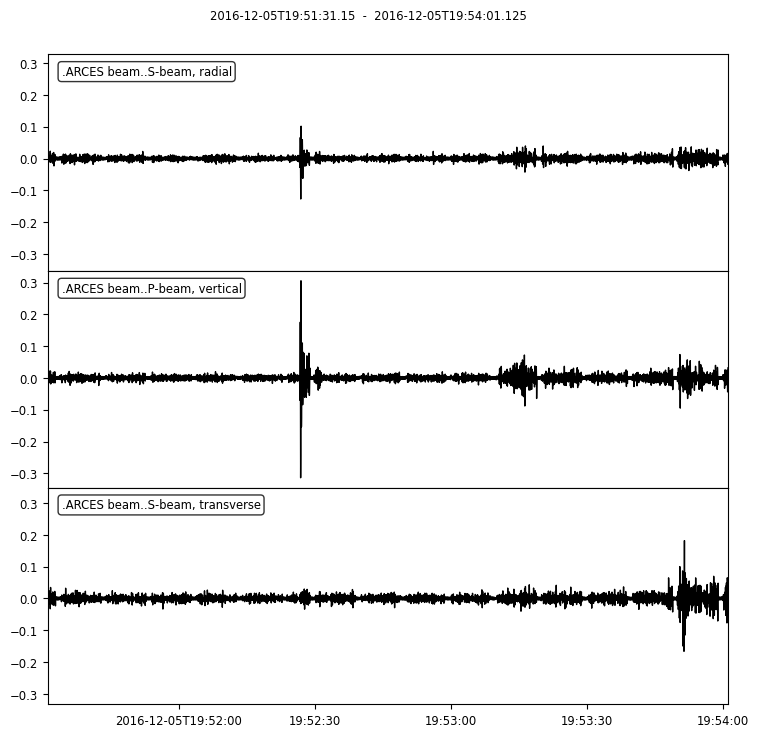

In [6]:
sample_trace = train_trace[1]
sample_label = train_label[1]
original_trace, sample_info = handler.path_to_trace(train_ds[1][0])
helper.plot_event(sample_trace, sample_info)

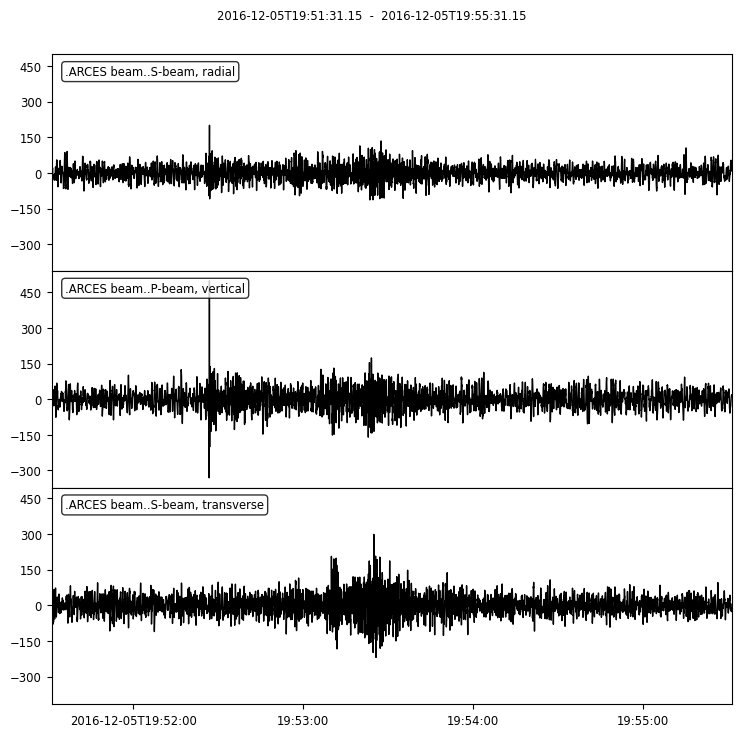

In [7]:
helper.plot_event(original_trace, sample_info)

In [8]:
sample_trace

array([[ 0.        ,  0.00029913,  0.0052986 , ..., -0.03894275,
        -0.00930834,  0.03173123],
       [ 0.        ,  0.0374872 ,  0.03214804, ..., -0.04488088,
        -0.067822  , -0.04638011],
       [ 0.        ,  0.00855761,  0.02113059, ..., -0.01790643,
        -0.00728692,  0.00929398]])